# Automating Provenance And Memoization For STARE-based Integrative Analysis Experiment

## STARE-based Integrative Analysis of Diverse Data Using Dask Parallel Programming Demo Paper


STARE Spatio Temporal Adaptive Resolution Encoding for Integrative Data Analysis is supported by NASA ACCESS-17, Federal Award ID No. 80NSSC18M0118.

---

## Preliminaries

### Dependencies and Building

This notebook depends on the following.

- [STARE](https://github.com/SpatioTemporal/STARE) - the fundamental API
- [pystare](https://github.com/SpatioTemporal/pystare) - the Python API
- [STAREPandas](https://github.com/SpatioTemporal/STAREPandas) - a STARE-aware dataframe
- [STAREmaster](https://github.com/SpatioTemporal/STAREmaster) - for constructing sidecar files with translation tables

While not requiring the cloud to run, this notebook was developed in the SMCE environment and uses cloud access permissions and configurations set up there. These are beyond the scope of this presentation. It should run well in non-cloud environments.

### Modules

In [27]:
from time import process_time
pt0 = process_time()

from time import time as wall_clock
wc0 = wall_clock()

import pystare as ps

from netCDF4 import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

import geodata as gd

import numpy

from sortedcontainers import SortedDict

from PIL import Image
Image.MAX_IMAGE_PIXELS = None


import os
import sys
import time
import glob
from io import BytesIO
from pprint import pprint

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely
import tempfile

%matplotlib inline
# %matplotlib notebook



## Helper Functions

### An object for caching some STARE results for matplotlib

In [2]:
class spatial_info(object):
    """
    Cache results of calculations used by matplotlib's tri package. By default,
    attempt to avoid rendering triangles that cross the branch cut incorrectly.
    """
    def __init__(self,spatial_index_values):
        "Construct a tri.Triangulation object for future rendering."
        if spatial_index_values is not None:
            # Calculate vertices and interconnection matrix
            self.index_values = spatial_index_values
            self.lons,self.lats,self.intmat = ps.triangulate_indices(spatial_index_values)
            self.triang = tri.Triangulation(self.lons,self.lats,self.intmat)
            self.derectify_cut()
            
    def derectify_cut(self,cut=180,arclimit=270):
        "First attempt at keeping triangles from stretching the wrong way across globe."
        d = numpy.zeros([3],dtype=numpy.double)
        for i in self.intmat:
            d[0] = self.lons[i[1]]-self.lons[i[0]]
            d[1] = self.lons[i[2]]-self.lons[i[1]]
            d[2] = self.lons[i[0]]-self.lons[i[2]]
            
            lon_toobig_count = 0
            for j in d:
                if abs(j) > arclimit:
                    lon_toobig_count += 1
            
            # print('lon_toobig_count ',lon_toobig_count)
            if lon_toobig_count > 0:
                lon_pos_counter = 0
                for j in i:
                    # print(j,eInfo.lons[j],eInfo.lats[j])
                
                    if self.lons[j] > 0:
                        lon_pos_counter += 1
                # print('lon_pos_counter: ',lon_pos_counter)
                if lon_pos_counter == 2:
                    for j in i:
                        if self.lons[j] < 0:
                            # print('ping 100',eInfo.lons[j])
                            self.lons[j] = self.lons[j] + 360.0
                            # print('ping 101',eInfo.lons[j])
                elif lon_pos_counter == 1:
                    for j in i:
                        if self.lons[j] > 0:
                            # print('ping 200')
                            self.lons[j] = self.lons[j] - 360.0  
        return


In [3]:
# Test spatial_info
if False:
    eInfo = spatial_info([882705526964617219,1684346260636565507])
    print('eInfo intmat',eInfo.intmat)
    print('eInfo lons  ',eInfo.lons)

### Visualization and Projection

#### Capture in one place some of the quirks of matplotlib and cartopy usage

In [4]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from time import process_time

# Some helper functions for plotting & printing.

def mnmx(a):
    return numpy.amin(a),numpy.amax(a)
def span(a):
    return numpy.amax(a)-numpy.amin(a)

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=0
        ,fixdateline=False
        ,figsize=None
        ,profile=False
        ):

    t0 = process_time()
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        t1 = process_time()
        
        if dbg>0:
            print('lons: ',mnmx(lons))
            print('lats: ',mnmx(lats))
            # print('lons: ',lons)
            # print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))
    else:
        t1 = process_time()

    if figax is not None:
        plot_options = figax.plot_options
    
    if plot_options is None:
        if spatial_index_values is not None:
            mnx  = mnmx(lons)
            if fixdateline:
                s = span(lons)
                if s > 270:
                    clon = ((0.5 * (sum(mnx)+180))%360)-180
                else:
                    clon = 0.5*sum(mnx)
            else:
                clon = 0.5*sum(mnx)
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=clon
                    # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                             )
            ,'transform':ccrs.Geodetic()}
            if dbg>0:
                print('hp-po central_longitude: ',clon)
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=figsize),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw,rasterized=True)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg>0:
        return figax,lons,lat,intmat
    
    tfinal = process_time()
    if profile:
        tpystare = t1-t0
        tnonpystare = tfinal-t1
        ttotal = tfinal-t0
        print('hello_plot pystare time %f (%2f)'%(tpystare,int(100*(tpystare/ttotal))))
        print('hello_plot total time   %f'%(ttotal))
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

### STARE Support for the [MERRA-2 Grid](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Grids are relatively easy and straightforward to support
- NASA's Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2), is a popular data set for Earth Science research
- Data available at https://disc.sci.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=MERRA2_400.tavg1_2d_slv_Nx
- For example: https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/2019/12/

In [5]:
class merra2_sidecar(object):
    "Convenience class for the relatively coarse MERRA-2 Grid."
    def __init__(self,cover_resolution = 0):
        self.nlat = 361
        self.nlon = 576
        self.dlat = 0.5 # or 180.0/(nlat-1)
        self.dlon = 5.0/8.0 # or 360.0/(nlon)
        self.lat1d = self.dlat*numpy.arange(self.nlat)-90.0
        self.lon1d = self.dlon*numpy.arange(self.nlon)-180.0
        self.dLatkm = self.dlat * gd.re_km/gd.deg_per_rad
        self.dLonkm  = self.dlon * gd.re_km/gd.deg_per_rad
        self.lon,self.lat = numpy.meshgrid(self.lon1d,self.lat1d)
        self.lat_flat     = self.lat.flatten()
        self.lon_flat     = self.lon.flatten()
        self.idx_ij       = numpy.arange(self.lat_flat.size,dtype=numpy.int64)
        self.resolution   = int(gd.resolution(self.dLonkm*2))
        self.cover_resolution = cover_resolution
        self.index        = ps.from_latlon(self.lat_flat,self.lon_flat,self.resolution)
        di = ps.spatial_increment_from_level(self.cover_resolution)
        self.cover        = [self.cover_resolution+(i*di) for i in range(8*(4**self.cover_resolution))]
        
m2_sidecar = merra2_sidecar()

In [6]:
# Load a MERRA-2 total precipitable water (TQV) dataset to use as an example. Note use of S3. Just replace with filepath if local.
ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4")

In [7]:
# Extract the dataset
tqv_flat = ds['TQV'][0,:,:].flatten()
# figax = hello_plot(show=False)
# print('m2_sidecar lon,lat: ',m2_sidecar.lon_flat.shape,m2_sidecar.lat_flat.shape,tqv_flat.shape)
# figax.ax.scatter(m2_sidecar.lon_flat,m2_sidecar.lat_flat,s=0.5,c=tqv_flat,transform=ccrs.PlateCarree(),cmap='rainbow')
# plt.show()

In [8]:
ds.close()

## STARE HTM Geolocation

- HTM: Hierarchical Triangular Mesh - A recursive tree encoded, indexed with integers
- Trixel -- Triangular 'Picture' Element - the spatial part of STARE
- [STARE Cookbook Examples](https://github.com/SpatioTemporal/STARE-Cookbooks/tree/master/contrib/jupyter)
- Root level, octahedron
- Motivation - universal, not tied to any particular instrument resolution or data layout in memory
- The neighborhood part -- geolocation always indexed at the leaf of the hierarchy

In [9]:
def trixels_at_level(cover_resolution = 0,title=None):
    "Step through and plot trixels on a particular level of the quadtree."
    di = ps.spatial_increment_from_level(cover_resolution)
    cover = [cover_resolution+(i*di) for i in range(8*(4**cover_resolution))]
    hello_plot(cover,show=False)
    if title is not None:
        plt.title(title)
    return cover

In [10]:
if False:
    cover = trixels_at_level(0,title='The root octahedron')
    cover = hello_plot([1+(i*ps.spatial_increment_from_level(1)) for i in range(4)],show=False); plt.title('The first recursive subdivision (level=1)')
    cover = trixels_at_level(1,title='Level 1')
    cover = trixels_at_level(2,title='Level 2')
    plt.show()

## STARE HTM Trixel Neighborhoods

### Provide an example of a STARE HTM index value, showing location and neighborhood information

In [11]:
# Set longitude and latitude in degrees to the summit of Mauna Loa.
MaunaLoa_lon = -155.602778
MaunaLoa_lat =   19.479444

lon = MaunaLoa_lon
lat = MaunaLoa_lat

In [12]:
# Set longitude and latitude in degrees
# lon = -155.602778
# lat =   19.479444

# Set the length scale of a neighborhood triangular element (trixel) about the location.
resolution_scale_km = 1000*km

# Determine the resolution, i.e. the level of the spatial quadtree, of that length scale.
spatial_resolution_level = int(ps.spatial_resolution_from_km(resolution_scale_km))

# Calculate the spatial index value.
spatial_id = ps.from_latlon([lat],[lon],spatial_resolution_level)

# Print to check.
print('resolution (%f km) ~ level = %i, (float %f)'%(resolution_scale_km
                                          ,spatial_resolution_level
                                          ,ps.spatial_resolution_from_km(resolution_scale_km)))
print('(lon,lat)=(%f,%f) -> spatial_id = %s'%(lon,lat,hex16(spatial_id[0])))
print()
print('Full spatial id:              %s'%(hex16(spatial_id[0])))
print('Geolocation part (bits 61-5): %s'%(hex16(spatial_id[0] & (~31))))
print('Resolution part  (bits  4-0): %s'%(hex16(spatial_id[0] & ( 31))))

resolution (1000.000000 km) ~ level = 3, (float 3.356144)
(lon,lat)=(-155.602778,19.479444) -> spatial_id = 0x2c2401f47797ec43

Full spatial id:              0x2c2401f47797ec43
Geolocation part (bits 61-5): 0x2c2401f47797ec40
Resolution part  (bits  4-0): 0x0000000000000003


In [13]:
if False:
    # Plot the trixel associated with the spatial index value
    figax = hello_plot(show=False,plot_options=plot_options)
    figax = hello_plot(spatial_id,figax=figax,show=False)

    # Go to a finer resolution
    if False:
        figax = hello_plot(spatial_id+1,figax=figax,show=False)

    # Go to finer resolutions, all the way to level=10, 10km.
    if False:
        for lvl in range(8):
            figax = hello_plot(spatial_id+2+lvl,figax=figax,show=False)

    # Plot the geolocation (lon,lat) as a red dot.
    figax.ax.scatter([lon],[lat],s=10,c='r',transform=plot_options['projection'])
    plt.title('Both location and neighborhood (level of tree) are encoded')
    plt.show()

## Gridded Earth Science Data

### Features of the popular longitude-latitude MERRA-2 grid (Level 3)
- high level vs. low level
    - High Level, gridded data, NASA Level 3
    - Low Level, non-gridded data, e.g. spacecraft swath data below, (Levels 1 and 2)
- coarse resolution 0.5x5/8
- 0 to ~50km pole to eq.
- longitude-latitude grid have lots of points at polar degeneracies
- STARE HTM trixels are more reasonable, more regular coverage, just one trixel or path through the tree



#### Display gridded data using matplotlib and cartopy. Be careful with projections and transformations!

In [31]:
# ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4")
ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191222.nc4")

In [35]:
if False:
    figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=(8,8)),plot_options=plot_options)

    proj=figax.plot_options['projection']
    # transf=figax.plot_options['transform'] # broken
    transf=proj
    figax.ax = plt.axes(projection=proj)
    figax.ax.set_extent([-180,180,-90,90])
    plt.imshow(ds['TQV'][0,:,:],transform=transf,extent=[-180,180,-90,90])
    figax.ax.coastlines()
    figax.ax.gridlines(draw_labels=True,xlocs=20*numpy.arange(18)-180,ylocs=20*numpy.arange(9)-90)
    plt.title('Precipitable water data projected onto PlateCaree and a regular longitude-latitude grid.')
    plt.show()
    plt.close()
    del figax

#### Now overlay STARE trixels from a particular neighborhood/resolution level

In [36]:
if False:
    figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=(8,8)),plot_options=plot_options)

    # Construct MERRA-2 sidecar info including index and cover. E.g. m2_sc.cover
    m2_sc=merra2_sidecar(cover_resolution=3)
    
    plt.imshow(ds['TQV'][0,:,:],transform=transf,extent=[-180,180,-90,90])
    hello_plot(m2_sc.cover,figax=figax,show=False,color='red')
    figax.ax.coastlines()
    figax.ax.gridlines(draw_labels=True,xlocs=20*numpy.arange(18)-180,ylocs=20*numpy.arange(9)-90,color='cyan')
    # figax.ax.gridlines(draw_labels=True)
    plt.title('STARE trixels are similar in size and shape. STARE is a more natural way to represent geodata.')
    plt.show()
    plt.close()
    del figax

#### Extract precipitable water data for future examples

In [17]:
# ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4")
ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4")

In [18]:
tqv_flat = ds['TQV'][0,:,:].flatten()
if False:
    figax = hello_plot(show=False)
    print('m2_sidecar lon,lat: ',m2_sidecar.lon_flat.shape,m2_sidecar.lat_flat.shape,tqv_flat.shape)
    figax.ax.scatter(m2_sidecar.lon_flat,m2_sidecar.lat_flat,s=0.5,c=tqv_flat,transform=ccrs.PlateCarree(),cmap='rainbow')
    plt.show()

In [19]:
# figax = hello_plot(m2_sidecar.index)

In [20]:
ds['TQV'][0,:,:].shape

(361, 576)

In [21]:
ds.close()

## STARE Cover of a Level 2 (non-gridded) Granule of MODIS Swath Data

- There's more than just gridded data, a lot of work often goes into making grids from un-gridded data.
- Point, grid, swath are various forms (from NASA Earth Science).
- Spacecraft take data continuously. Archives organize it into granules, files, to make it manageable.
- Here we read STARE sidecar files that have STARE covers outlining the location of data stored in the granule.

The Moderate Resolution Imaging Spectroradiometer (MODIS) ison both the Terra and Aqua spacecraft.
- Project https://modis.gsfc.nasa.gov/data/
- Data available at https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD05_L2/2019/356/


In [37]:
# For use with S3, use starepandas.s3_glob
# files=glob.glob('/home/jovyan/data/*_stare.nc')
files=glob.glob('/home/jovyan/data/tmp/*.23??.*_stare.nc')

In [38]:
# Load a downward pass from Aqua. The sidecar files...
files.sort(); files

['/home/jovyan/data/tmp/MOD05_L2.A2019356.2300.061.2019357071834_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2305.061.2019357071834_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2310.061.2019357071855_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2315.061.2019357071844_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2335.061.2019357071855_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2340.061.2019357071827_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2345.061.2019357071839_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2350.061.2019357072255_stare.nc',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2355.061.2019357072753_stare.nc']

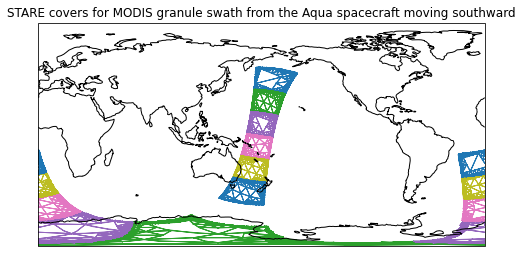

In [39]:
# Get and display the STARE covers from the sidecar files. Mostly IO and viz. here.

figax = hello_plot(set_global=True,show=False
                   ,plot_options = {'projection':ccrs.PlateCarree(central_longitude=170)
                                   ,'transform':ccrs.Geodetic()}
                  ,figsize=(8,8))
for filename in files:
    ds = Dataset(filename)
    cover = ds['STARE_cover_5km'][:].flatten().astype(numpy.int64) # The need to cast will eventually go away.
    ds.close()
    figax = hello_plot(cover,figax=figax,show=False)
plt.title('STARE covers for MODIS granule swath from the Aqua spacecraft moving southward')
plt.show()
plt.close()
del figax

In [40]:
# Take a look at the data files (5-minute granules)
# files=glob.glob('/home/jovyan/data/*.hdf'); files.sort(); files
files=glob.glob('/home/jovyan/data/tmp/*.hdf'); files.sort(); files

['/home/jovyan/data/tmp/MOD05_L2.A2019356.2310.061.2019357071855.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2315.061.2019357071844.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2330.061.2019357071858.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2335.061.2019357071855.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2340.061.2019357071827.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2345.061.2019357071839.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2350.061.2019357072255.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2355.061.2019357072753.hdf']

#### Open one of the granules and look at the data

In [52]:
ifile = 2
file=files[ifile]
print('loading ',file)
ds = starepandas.SD_wrapper(files[ifile])

loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf


In [53]:
# Extract the information
lat_5km = starepandas.with_hdf4_get(ds,'Latitude'); lon_5km = starepandas.with_hdf4_get(ds,'Longitude')

img_wvir = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared')
img_wvir,attrs = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared',attrs=['add_offset','scale_factor','_FillValue'])
img_wvir[numpy.where(img_wvir == attrs['_FillValue'])] = 0 # Or use a mask
img_wvir = (img_wvir-attrs['add_offset'])*attrs['scale_factor']

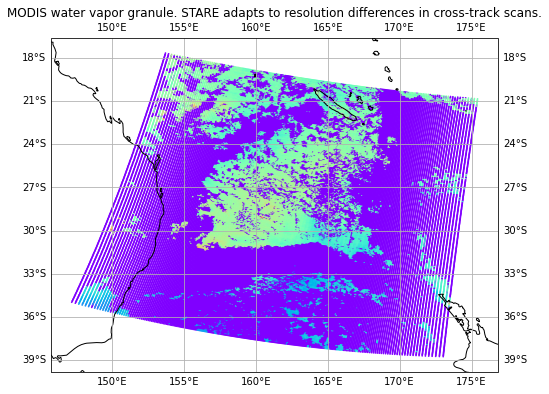

In [54]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(lon_5km,lat_5km,s=0.5,c=img_wvir,transform=ccrs.PlateCarree(),cmap='rainbow')
if False:
    plt.plot(
        (147.24422, 145.8304, 153.39551, 154.58578, 147.24422)
        ,(-18.62481, -23.020168, -24.507856, -20.038599, -18.62481), "o-",color='k',lw=2)
# ax.set_global()
# ax.set_extent([-50,50,0,90])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('MODIS water vapor granule. STARE adapts to resolution differences in cross-track scans.')
plt.show()

#### Spacecraft is moving south down the center of the above swath
- Fanning out of measurement is a projection effect (PlateCarree used)
- Note the measurements spread apart at wings (East & West edges of swath) as look-angle worsens

In [55]:
print('closing hdf4 file ',file); ds.end()

closing hdf4 file  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf


### Show STARE HTM with embedded location & neighborhood encoding adapts to multi-resolution data

In [67]:
# filename = '/home/jovyan/data/MOD05_L2.A2019336.2345.061.2019337072038_stare.nc'
filename = file[:-4]+"_stare.nc"
print('filename: ',filename)
ds = Dataset(filename)
index2d = ds['STARE_index_5km'][:,:]
ds.close() 
print('shape: ',index2d.shape)

filename:  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856_stare.nc
shape:  (406, 270)


In [70]:
cross0=0; cross1= int(270/4)
along0=0; along1= int(406/4)
index = index2d[along0:along1,cross0:cross1].flatten().astype(numpy.int64)

In [71]:
# "Bounding box"
print((lon_5km[along0,cross0],lon_5km[along1,cross0],lon_5km[along1,cross1],lon_5km[along0,cross1],lon_5km[along0,cross0]))
print((lat_5km[along0,cross0],lat_5km[along1,cross0],lat_5km[along1,cross1],lat_5km[along0,cross1],lat_5km[along0,cross0]))

(153.72737, 152.33513, 159.85205, 161.0253, 153.72737)
(-17.671118, -22.070877, -23.533413, -19.061111, -17.671118)


hello_plot pystare time 0.000007 (0.000000)
hello_plot total time   0.018377


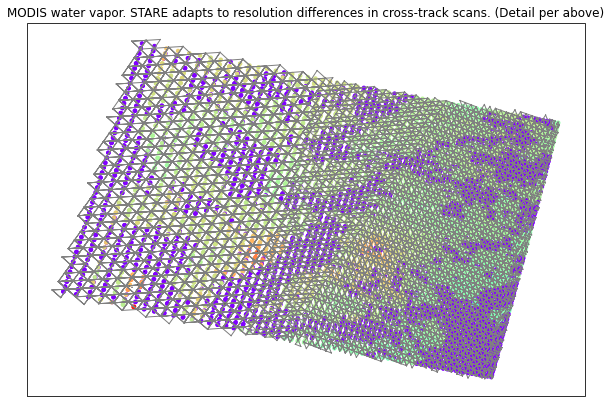

In [73]:
figax = hello_plot(set_global=False,show=False
                   ,plot_options = {'projection':ccrs.PlateCarree(central_longitude=170)
                                   ,'transform':ccrs.Geodetic()}
                  ,figsize=(10,10)
                  ,profile=True)
figax = hello_plot(index,figax=figax,show=False,color='grey')
plt.scatter(lon_5km[along0:along1,cross0:cross1],lat_5km[along0:along1,cross0:cross1],s=12,c=img_wvir[along0:along1,cross0:cross1]
            ,transform=ccrs.PlateCarree(),cmap='rainbow')
plt.title('MODIS water vapor. STARE adapts to resolution differences in cross-track scans. (Detail per above)')
plt.show()
plt.close()
del figax

# STARE adapts to the data.

## STARE Region of Interest (ROI)

- A set of STARE index values (integers, i.e. numbers)
- No special continuity required, can be multiply connected (i.e. multi-polygon)

In [76]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)

# roi = world[world.continent=='Oceania'] # Get a gdf from geopandas
roi = world[world.name=='Australia'] # Get a gdf from geopandas

# Convert the gdf to STARE
stare = starepandas.stare_from_gdf(roi, level=7, force_ccw=True)
roi = starepandas.STAREDataFrame(roi, stare=stare)

# The trixels are just for visualization
roi.set_trixels(inplace=True)
roi.head()

# roi_stare = world[world.name=='France']
# roi_stare = fetched_watershed['SanJoaqin']


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,stare,trixels
137,23232413,Oceania,Australia,AUS,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907...","[1302666192216915975, 1302701376589004807, 130...",(POLYGON ((146.2500001315569 -44.4442171587261...


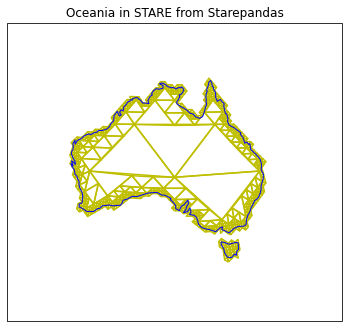

In [79]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(6,6))
ax.grid(True)
ax.set_extent([100,170,-50,0],ccrs.Geodetic())
# roi.drop(0).plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0) # Drop Fiji
roi.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
roi.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1, transform=plot_options['projection'])
plt.title('Oceania in STARE from Starepandas')
plt.show()

## STARE Sidecar Files and Cataloguing

### Construct a searchable catalog from the files in a folder
- S3 and local file system handled in the same way

In [80]:
# folder = 's3://daskhub-data/MODAPS/MOD05/'
folder = '/home/jovyan/data/tmp/'
catalogue = None
catalogue = starepandas.folder2catalogue(path=folder
                             ,granule_extension='hdf'
                             ,add_sf=True) # add_sf is not necessary

no sidecar found for /home/jovyan/data/tmp/MOD05_L2.A2019356.2330.061.2019357071858.hdf


In [81]:
catalogue.head()

,begining,ending,geom,granule_name,sidecar_name,stare_cover
0,2019-12-22 23:50:00,2019-12-22 23:55:00,"POLYGON ((5.51049 -47.27430, 5.45293 -47.19090...",/home/jovyan/data/tmp/MOD05_L2.A2019356.2350.0...,/home/jovyan/data/tmp/MOD05_L2.A2019356.2350.0...,"[2026619832316723204, 2071655828590428164, 207..."
1,2019-12-22 23:15:00,2019-12-22 23:20:00,"POLYGON ((158.26535 0.03472, 158.25267 -0.0545...",/home/jovyan/data/tmp/MOD05_L2.A2019356.2315.0...,/home/jovyan/data/tmp/MOD05_L2.A2019356.2315.0...,"[756604737398243332, 936748722493063172, 10088..."
2,2019-12-22 23:35:00,2019-12-22 23:40:00,"POLYGON ((113.44678 -65.48883, 113.27525 -65.5...",/home/jovyan/data/tmp/MOD05_L2.A2019356.2335.0...,/home/jovyan/data/tmp/MOD05_L2.A2019356.2335.0...,"[1918533441259831299, 1963569437533536260, 198..."
3,2019-12-22 23:25:00,2019-12-22 23:30:00,"POLYGON ((147.20651 -34.98159, 147.17113 -35.0...",/home/jovyan/data/tmp/MOD05_L2.A2019356.2325.0...,/home/jovyan/data/tmp/MOD05_L2.A2019356.2325.0...,"[1299288492496388100, 1308295691751129092, 131..."
4,2019-12-22 23:20:00,2019-12-22 23:25:00,"POLYGON ((153.72737 -17.67112, 153.70737 -17.7...",/home/jovyan/data/tmp/MOD05_L2.A2019356.2320.0...,/home/jovyan/data/tmp/MOD05_L2.A2019356.2320.0...,"[1315051091192184836, 1378101485975371780, 138..."


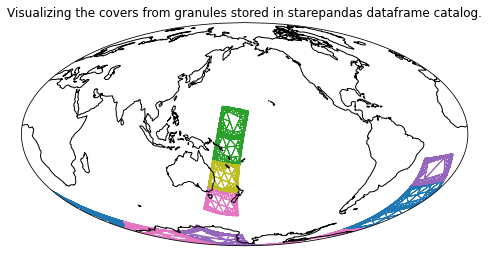

Wall clock timing:  3.313600540161133


In [83]:
wc_a = wall_clock()
figax=hello_plot(set_global=True,show=False
                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
                 ,figsize=(8,8)
                )
for i in catalogue['stare_cover']:
    hello_plot(i.data,figax=figax,show=False)
plt.title('Visualizing the covers from granules stored in starepandas dataframe catalog.')
plt.show()
plt.close()
del figax
print('Wall clock timing: ',wall_clock()-wc_a)

## Searching the Catalogue

Construct a STARE cover for an ROI and search catalog for granules that intersect.

In [87]:
# roi_stare = roi[roi.name=='Australia'].stare.iloc[0];  # roi_stare
# roi_stare = roi.stare.iloc[0]
roi_stare = roi.stare.iloc[0]

In [88]:
# Here's the query... Note, just one line.
cover_intersects = catalogue.stare_intersects(roi_stare)


# Extract the file names for future use.
granule_subset = catalogue[cover_intersects].granule_name

# Print some diagnostics..
msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 2 granules intersecting the ROI


3    /home/jovyan/data/tmp/MOD05_L2.A2019356.2325.0...
4    /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.0...
Name: granule_name, dtype: object

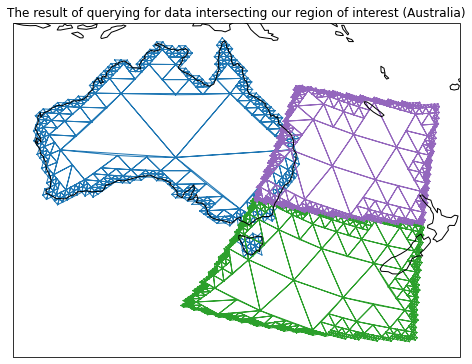

In [89]:
# And display directly from the catalogue...
figax=hello_plot(set_global=False,show=False,figsize=(8,8))
hello_plot(roi_stare,figax=figax,show=False)
for i in granule_subset.keys():
    hello_plot(catalogue['stare_cover'][i].data,figax=figax,fixdateline=False,show=False)
plt.title('The result of querying for data intersecting our region of interest (Australia)')
plt.show()

### Trim the covers to their intersections with the ROI.

In [90]:
wc_a = wall_clock()

# Determine the intersections
intersections = [
    ps.intersect(roi_stare,catalogue['stare_cover'][i].data,1) for i in granule_subset.keys()
]

print('Wall clock timing: ',wall_clock()-wc_a)

Wall clock timing:  0.013700246810913086


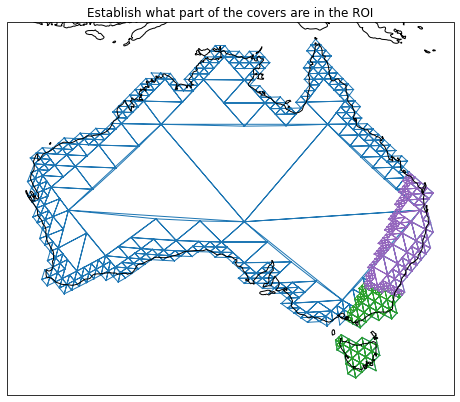

In [91]:
# And display the intersections and the ROI
figax=hello_plot(set_global=False,set_coastlines=True,show=False,figsize=(8,8)
                                    ,plot_options = {'projection':ccrs.PlateCarree(central_longitude=170)
                                   ,'transform':ccrs.Geodetic()}
                )
for cover in [roi_stare]+intersections:
    figax=hello_plot(cover,figax=figax,fixdateline=False,show=False)
# roi.plot(ax=figax.ax, trixels=False, facecolor="none", edgecolor='k', zorder=1, transform=plot_options['projection'],lw=2)
plt.title('Establish what part of the covers are in the ROI')
plt.show()

## Subsetting the Data

Reach back to the granules (the legacy data files), load the data, and use the intersections against the sidecar's index to determine which native array index values to keep.

In [92]:
# With which granules are we working?
granule_names = list(granule_subset); granule_names

['/home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf']

In [93]:
class modis_data(object):
    "Convenience class for loading and working with MODIS MOD05_L2 data and its sidecars."
    def __init__(self,file):
        "Open a MODIS MOD05_L2 granule and extract key data for future use."
        print('loading ',file)
        self.file=file
        ds = starepandas.SD_wrapper(self.file)
        self.lat_5km = starepandas.with_hdf4_get(ds,'Latitude');
        self.lon_5km = starepandas.with_hdf4_get(ds,'Longitude')
        self.img_wvir = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared')
        self.img_wvir,self.attrs = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared',attrs=['add_offset','scale_factor','_FillValue'])
        self.img_wvir[numpy.where(self.img_wvir == self.attrs['_FillValue'])] = 0 # Or use a mask
        self.img_wvir = (self.img_wvir-self.attrs['add_offset'])*self.attrs['scale_factor']
        self.scan_start_time = starepandas.with_hdf4_get(ds,'Scan_Start_Time') # TAI - seconds since 1993-1-1 00:00:00.0 0
        ds.end()

        sidecar_file='.'.join(file.split('.')[0:-1])+'_stare.nc'
        print('loading ',sidecar_file)
        self.sidecar_file=sidecar_file
        ds = starepandas.nc4_Dataset_wrapper(sidecar_file)
        self.index2d = ds['STARE_index_5km'][:,:].astype(numpy.int64)
        self.lat2d   = ds['Latitude_5km'][:,:]
        self.lon2d   = ds['Longitude_5km'][:,:]
        ds.close()
        return
    
class modis_subset(object):
    "Convenience class for working with STARE cover-based subsetting."
    def __init__(self,obj,target_cover):
        "Construct a subset from a STARE roi target cover and a modis_data object."
        
        # Here's the pystare call that figures out what to keep
        self.idx          = ps.intersects(target_cover,obj.index2d.flatten(),1) # Method 1 is a binary sort-search, modifies the left argument.
        
        # Do the subsetting
        self.subset_idx   = numpy.where(self.idx>0)
        self.subset_index = obj.index2d.flatten() [self.subset_idx]
        self.subset_lat   = obj.lat2d.flatten()   [self.subset_idx]
        self.subset_lon   = obj.lon2d.flatten()   [self.subset_idx]
        self.subset_wvir  = obj.img_wvir.flatten()[self.subset_idx]
        
        self.subset_scan_start_time = obj.scan_start_time.flatten()[self.subset_idx]
        return
    
    def mnmx(self):
        "Determine min & max, e.g. for graphics scaling."
        return numpy.amin(self.subset_wvir),numpy.amax(self.subset_wvir)

#### Load the data

In [95]:
data_objs = [modis_data(name) for name in granule_names]

loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840.hdf
loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840_stare.nc
loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf
loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856_stare.nc


#### Use intersections to trim (subset) the granules down

In [96]:
intersected_objs = [modis_subset(data_objs[i],intersections[i]) for i in [0,1]]

#### And display...

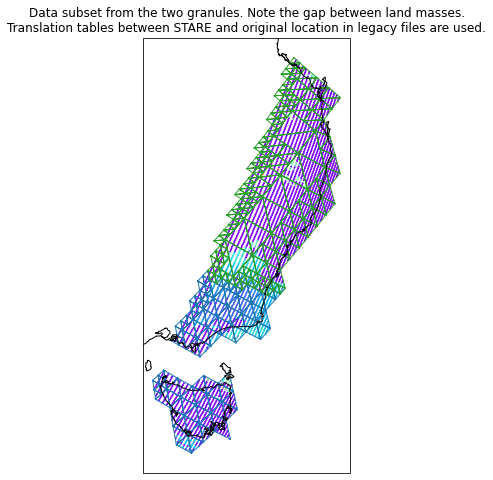

In [97]:
figax = hello_plot(show=False,figsize=(8,8))
figax = hello_plot(intersections[0],show=False,figax=figax)
figax = hello_plot(intersections[1],show=False,figax=figax)

for io in intersected_objs:
# io=intersected_objs[1]    
# if True:
    plt.scatter(io.subset_lon,io.subset_lat,s=0.5,c=io.subset_wvir,transform=ccrs.PlateCarree(),cmap='rainbow'
                ,vmin=0
                ,vmax=5
               )

# ax.set_global()
# ax.set_extent([-50,50,0,90])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('Data subset from the two granules. Note the gap between land masses.\nTranslation tables between STARE and original location in legacy files are used.')
plt.show()

In [48]:
# Misc. checks
# [o.mnmx() for o in intersected_objs]
# !~/opt/local/bin/aws s3 ls s3://daskhub-data/MODAPS/CATALOGS/MOD05_L2/2019/356/catalogue.sqlite

## Catalog (reprise)

### Now repeat the above for the full non-globbed data

In [102]:
if False:
    # First, load a previously generated catalogue.
    db_path = '/home/jovyan/data/catalogue.sqlite' 
    # db_path = 's3://daskhub-data/MODAPS/CATALOGS/MOD05_L2/2019/356/catalogue.sqlite'
    uri = 'sqlite:///{db_path}'.format(db_path=db_path)
    engine = sqlalchemy.create_engine(uri)
    catalog2 = pandas.read_sql(sql='catalogue', con=engine)
    # Geometry and STARE are stored in blobs, so we need to deserialize (will likely be simplified in the future)
    catalog2.stare_cover = catalog2.stare_cover.apply(func=numpy.frombuffer, args=('int64',))
    catalog2.geom = catalog2.geom.apply(shapely.wkb.loads, args=(True,))
    # We convert the conventional DF to a STAREDataFrame and set the stare column (will likely be simplified in the future)
    catalog2019356 = starepandas.STAREDataFrame(catalog2019356, stare='stare_cover')
else:
    # Or generate a new one.
    folder = '/home/jovyan/data/tmp/'
    catalog2 = None
    catalog2 = starepandas.folder2catalogue(path=folder
                                 ,granule_extension='hdf'
                                 ,add_sf=True) # add_sf is not necessary
    


no sidecar found for /home/jovyan/data/tmp/MOD05_L2.A2019356.2330.061.2019357071858.hdf


#### Search the catalogue for granules overlapping the ROI (Australia)

In [103]:
# Here is the STARE query
cover_intersects2 = catalog2.stare_intersects(roi_stare)

# Get the names and print some diagnostics (mostly rearranging)
granule_subset2 = catalog2[cover_intersects2].granule_name
msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset2))
print(msg)
granule_subset2.head()

there are 2 granules intersecting the ROI


3    /home/jovyan/data/tmp/MOD05_L2.A2019356.2325.0...
4    /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.0...
Name: granule_name, dtype: object

In [104]:
granule_names2 = list(granule_subset2); granule_names2

['/home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840.hdf',
 '/home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf']

#### And display the granule covers from the catalog.

It can take some time to render the 260+ covers in matplotlib and cartopy. Parallel rendering is on the roadmap.

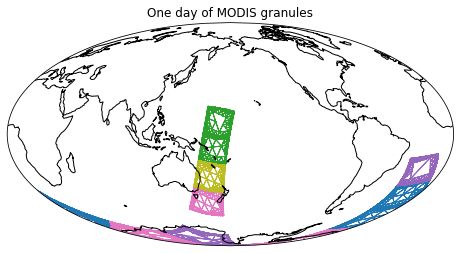

Wall clock time:  3.301509380340576


In [105]:
wc_a = wall_clock()
figax=hello_plot(set_global=True,show=False
                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
                 ,figsize=(8,8)
                 ,profile=False
                )
for i in catalog2['stare_cover']:
    hello_plot(i.data,figax=figax,show=False,profile=False)
plt.title('One day of MODIS granules')
plt.show()
print('Wall clock time: ',wall_clock()-wc_a)

#### Display the covers of the granules that overlap the ROI.

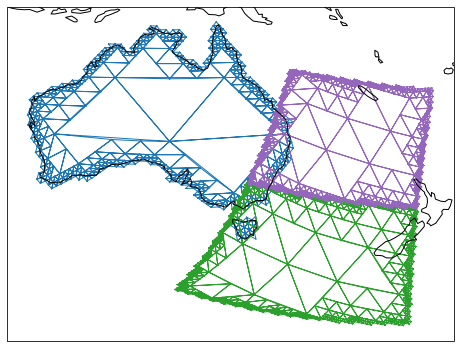

In [106]:
figax=hello_plot(set_global=False,show=False,figsize=(8,8)
                                    ,plot_options = {'projection':ccrs.PlateCarree(central_longitude=170)
                                   ,'transform':ccrs.Geodetic()})
hello_plot(roi_stare,figax=figax,show=False)
for i in granule_subset2.keys():
    hello_plot(catalog2['stare_cover'][i].data,figax=figax,fixdateline=False,show=False)
plt.show()

#### Now trim the granule covers to the ROI.

In [107]:
wc_a = wall_clock()

# The STARE intersection
intersections2 = [
    ps.intersect(roi_stare,catalog2['stare_cover'][i].data,1) for i in granule_subset2.keys()
]
print('Wall clock timing: ',wall_clock()-wc_a)
print('number of intersection: ',len(intersections2))

Wall clock timing:  0.016934633255004883
number of intersection:  2


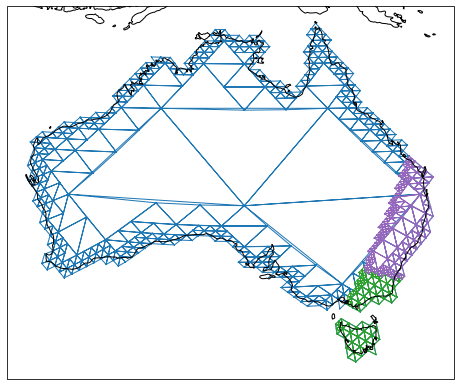

In [108]:
# And display...
figax=hello_plot(set_global=False,show=False,figsize=(8,8))
for cover in [roi_stare]+intersections2:
    hello_plot(cover,figax=figax,fixdateline=False,show=False)
plt.show()

### Load the data from the granules, and subset according to the intersections.

In [110]:
# Load the data into convenience objects
data_objs2 = [modis_data(name) for name in granule_names2]

# Perform subsetting
intersected_objs2 = [modis_subset(data_objs2[i],intersections2[i]) for i in range(len(intersections2))]

loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840.hdf
loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2325.061.2019357071840_stare.nc
loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856.hdf
loading  /home/jovyan/data/tmp/MOD05_L2.A2019356.2320.061.2019357071856_stare.nc


#### And display the subsetted data...

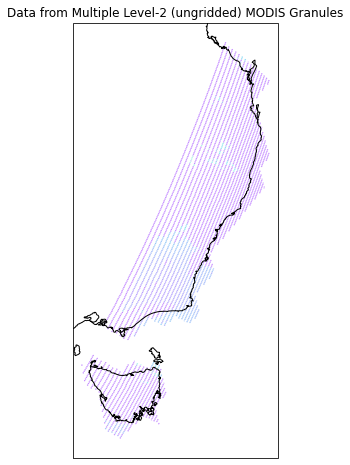

In [111]:
figax = hello_plot(show=False,figsize=(8,8))

if False:
    for i in intersections2:
        figax = hello_plot(i,show=False,figax=figax)

for io in intersected_objs2:
    plt.scatter(io.subset_lon,io.subset_lat,s=0.05,c=io.subset_wvir,transform=ccrs.PlateCarree()
                ,cmap='rainbow',alpha=0.5
                ,vmin=0.0,vmax=9.5
               )

# ax.set_global()
# ax.set_extent([-50,50,0,90])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('Data from Multiple Level-2 (ungridded) MODIS Granules')
plt.show()

In [59]:
# roi_stare

## Dealing with diverse data: Recall the gridded MERRA-2 data

As an example, index the MERRA-2 data just as we indexed MODIS data above. Since MERRA-2 is gridded, we'll use the grid we defined above with our sidecar function.

The following few cells replicate the logic seen in modis_subset above.

In [60]:
# m2_sidecar.index.shape # Our STARE Sidecar index size

In [112]:
# Harmonization --

# Now subset the MERRA-2 data
# m2_sc=merra2_sidecar(cover_resolution=3) # Make a new "sidecar," if needed.

# Determine where MERRA-2 intersects the ROI
m2_idx0 = ps.intersects(roi_stare,m2_sidecar.index,1) # Compare the ROI cover with the MERRA-2 sidecar cover

In [113]:
# Prepare a Numpy array to subset the data arrays
m2_idx1 = numpy.where(m2_idx0>0) # For selecting data from M2 arrays

In [63]:
# print(numpy.amax(m2_idx1))

In [114]:
# Open the "granule"
# ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191222.nc4")
ds = starepandas.nc4_Dataset_wrapper("/home/jovyan/data/MERRA2_400.tavg1_2d_slv_Nx.20191222.nc4")

In [115]:
# Load the data
m2_tqv_flat=ds['TQV'][0,:,:].flatten() # Only use the first slice (time) of data

In [116]:
# Subset according to our index trimmed by STARE
subset_m2_index = m2_sidecar.index[m2_idx1] # An index into the array indices.
subset_lon      = m2_sidecar.lon_flat[m2_idx1]
subset_lat      = m2_sidecar.lat_flat[m2_idx1]
subset_tqv      = m2_tqv_flat[m2_idx1]

In [117]:
print(numpy.amin(subset_tqv),numpy.amax(subset_tqv)) # Capture max & mins of observation to control visualization coloring

3.652144 59.550583


#### And display the subsetted MERRA-2 data...

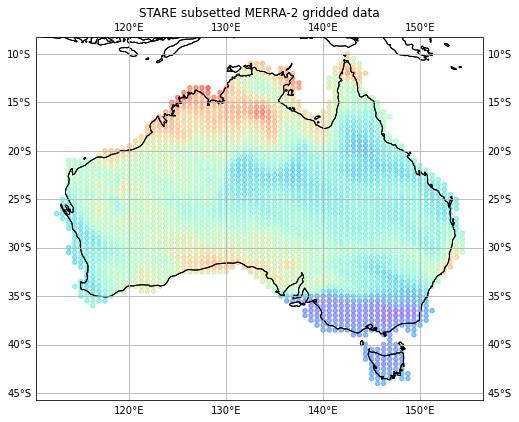

In [119]:
figax = hello_plot(show=False,figsize=(8,8))

if False:
    for i in intersections2:
        figax = hello_plot(i,show=False,figax=figax)

plt.scatter(subset_lon,subset_lat,s=20.0,c=subset_tqv,transform=ccrs.PlateCarree()
            ,cmap='rainbow',alpha=0.5
            #,vmin=0.0,vmax=9.5
            #,vmin=5.6690903,vmax=59.796043
            ,vmin=0,vmax=59.796043
            )

# ax.set_global()
# ax.set_extent([-50,50,0,90])
figax.ax.coastlines()
figax.ax.gridlines(draw_labels=True)
plt.title('STARE subsetted MERRA-2 gridded data')
plt.show()
plt.close()
del figax

### Trixel-based Integration

#### First, display the MODIS (small circles) and MERRA-2 (large circles) data, as well as the MERRA-2 cover (in black)
- Note, the black trixels can be used to organize the data...

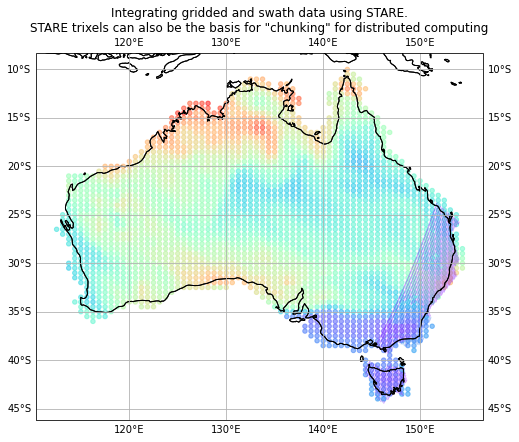

In [120]:
figax = hello_plot(show=False,figsize=(8,8))

if False:
    for i in intersections2:
        figax = hello_plot(i,show=False,figax=figax)

if True:
    plt.scatter(subset_lon,subset_lat,s=20.0,c=subset_tqv,transform=ccrs.PlateCarree()
                ,cmap='rainbow',alpha=0.5
                ,vmin=0,vmax=59.796043
                #,vmin=5.6690903,vmax=59.796043
                )
    
if True:
    for io in intersected_objs2:
        plt.scatter(io.subset_lon,io.subset_lat,s=0.05,c=io.subset_wvir,transform=ccrs.PlateCarree()
                    ,cmap='rainbow',alpha=0.3
                    ,vmin=0.0,vmax=9.5
                   )
if False:
    # Use the color grey to note that the trixels are not containers, no data has been binned into them.
    figax = hello_plot(m2_sidecar.index[m2_idx1],figax=figax,show=False,color='grey')

# ax.set_global()
# ax.set_extent([-50,50,0,90])
figax.ax.coastlines()
figax.ax.gridlines(draw_labels=True)
plt.title('Integrating gridded and swath data using STARE.\nSTARE trixels can also be the basis for "chunking" for distributed computing')

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.show()
figax.fig.savefig('IntegratingGriddedAndSwath.svg')

# The following plots three different data sets. MODIS (small dots) , MERRA-2 (larger dots), and a level-6 chunking of Australia with trixels.

In [121]:
# Construct the subsetting index for the MERRA-2 sidecar
subset_m2_index = m2_sidecar.index[m2_idx1] # STARE index values for the array positions in m2_idx1

## Let's actually _HARMONIZE_ the data trixel-by-trixel

### We'll use the trixels above as entries in a Python dictionary for further use.

In [122]:
class harmonized_data_entry(object):
    "A container to collect the diverse data."
    def __init__(self):
        self.entry = {}
        
        # We don't actually need the following if we have merra2 & modis entry objects...
        
        # Containers for what we find in a trixel
        self.entry['merra2']     = []
        self.entry['merra2_siv'] = []
        self.entry['merra2_lat'] = []
        self.entry['merra2_lon'] = []
        
        self.entry['modis']      = []
        self.entry['modis_siv']  = []
        self.entry['modis_lat']  = []
        self.entry['modis_lon']  = []
    

In [72]:
# len(subset_tqv)

In [123]:
# Could also use 'from sortedcontainers import SortedDict', note the ordering can provide some optimization options.

# Make a new good ol' Python Dictionary
harmonized_data = {}


#### Load the MERRA-2 data into the dictionary

In [124]:
# subset_tqv aligns with subset_m2_index

# for i in range(3):
# for i in range(100):
for i in range(len(subset_tqv)):
    sid0 = subset_m2_index[i]
    sid = gd.spatial_clear_to_resolution(sid0)

    try:
        harmonized_data[sid].entry # Check if the entry exists
    except:
        harmonized_data[sid] = harmonized_data_entry() # Add a new entry if it doesn't
        pass
    
    harmonized_data[sid].entry['merra2']    .append(subset_tqv[i]) # keep the data
    
    harmonized_data[sid].entry['merra2_siv'].append(sid0)          # keep full location information
    harmonized_data[sid].entry['merra2_lat'].append(subset_lat[i])
    harmonized_data[sid].entry['merra2_lon'].append(subset_lon[i])

target_resolution = int(subset_m2_index[0] & 31) # single-resolution grid data...

# print(harmonized_data)

In [75]:
# harmonized_data.keys()
# sid & 31

#### And display...

Previously, we iterated over the intersected objects subsetted from the original data.

The data here have been re-organized into trixels, with each entry in the harmonized_data dictionary correponding to a trixel. Note the iteration over the harmonized_data below.

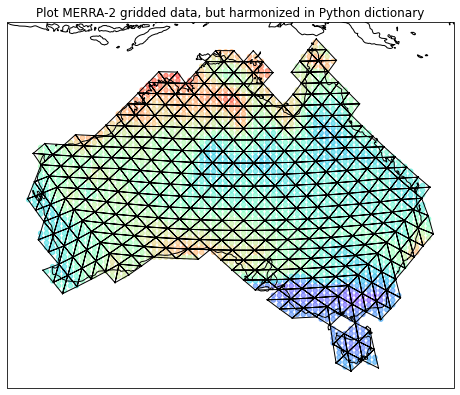

In [125]:
figax = hello_plot(show=False,figsize=(8,8)); 

figax = hello_plot(list(harmonized_data.keys()),figax=figax,show=False,color='k')

for key in harmonized_data:
    i = harmonized_data[key]
    # Check for data, if so, display.
    if len(i.entry['merra2_lon']) > 0:
        plt.scatter(i.entry['merra2_lon'],i.entry['merra2_lat'],s=20,c=i.entry['merra2'],transform=ccrs.PlateCarree()
                    ,cmap='rainbow',alpha=0.5
                    #,vmin=5.6690903,vmax=59.796043
                    ,vmin=0,vmax=59.796043
                    )
plt.title('Plot MERRA-2 gridded data, but harmonized in Python dictionary')
plt.show()

# Each trixel is now a container loaded with harmonized MERRA-2 data.

#### Now harmonize the MODIS data

In [127]:
# io = harmonized_objs2[0]
# if True:
for io in intersected_objs2:
    for i in range(len(io.subset_index)):
        sid0 = io.subset_index[i]
        sid  = gd.spatial_clear_to_resolution(gd.spatial_coerce_resolution(sid0,target_resolution))
        
        try:
            harmonized_data[sid].entry['modis']    .append(io.subset_wvir[i]) # keep the data
            harmonized_data[sid].entry['modis_siv'].append(sid0)             # keep full location information
        
            harmonized_data[sid].entry['modis_lat'].append(io.subset_lat[i])
            harmonized_data[sid].entry['modis_lon'].append(io.subset_lon[i])
            
        except:
            pass

#### And display...

Note again the iteration over the dictionary. This time plotting both MERRA-2 and MODIS data from the dictionary entry, if available.

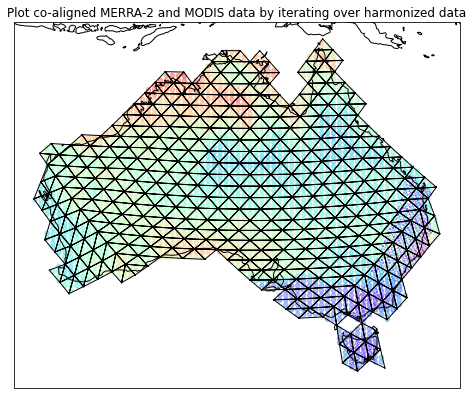

In [128]:
figax = hello_plot(show=False,figsize=(8,8)); 

figax = hello_plot(list(harmonized_data.keys()),figax=figax,show=False,color='k')

for key in harmonized_data:
    i = harmonized_data[key] # the entry at key
    
    if len(i.entry['merra2_lon']) > 0:
        plt.scatter(i.entry['merra2_lon'],i.entry['merra2_lat'],s=20,c=i.entry['merra2'],transform=ccrs.PlateCarree()
                    ,cmap='rainbow',alpha=0.4
                    #,vmin=5.6690903,vmax=59.796043
                    ,vmin=0,vmax=59.796043
                    )
    if len(i.entry['modis_lon']) > 0:
        plt.scatter(i.entry['modis_lon'],i.entry['modis_lat'],s=0.05
                    ,c=i.entry['modis'],transform=ccrs.PlateCarree()
                    ,cmap='rainbow',alpha=0.3,marker='s'
                    ,vmin=0.0,vmax=9.5
                    )

plt.title('Plot co-aligned MERRA-2 and MODIS data by iterating over harmonized data')
plt.show()

## Example: A Region of interest around Brisbane

A region of interest may be a single trixel, or a more complex region, perhaps with cut-outs.

Here we provide examples of a circular roi about Brisbane or the trixel about Brisbane itself.

In [130]:
brisbane_lat = -27.47126
brisbane_lon = 153.02385
brisbane_siv = ps.from_latlon([brisbane_lat],[brisbane_lon],int(target_resolution))[0]

roi2_radius = 3 # degrees

roi2_th = numpy.linspace(0, 2 * numpy.pi, 50)
roi2_la = brisbane_lat+roi2_radius*numpy.sin(roi2_th)
roi2_lo = brisbane_lon+roi2_radius*numpy.cos(roi2_th)
    
roi2  = ps.expand_intervals(ps.to_circular_cover(brisbane_lat,brisbane_lon,roi2_radius,int(target_resolution)),int(target_resolution))
roi0 = roi2

In [131]:
print(hex(brisbane_siv),target_resolution) # The STARE HTM spatial index value

0x1320066db76281c6 6


#### And display...

Change single to toggle visualizing Brisbane's trixel or the circular ROI. Note the looping over dictionary entries.

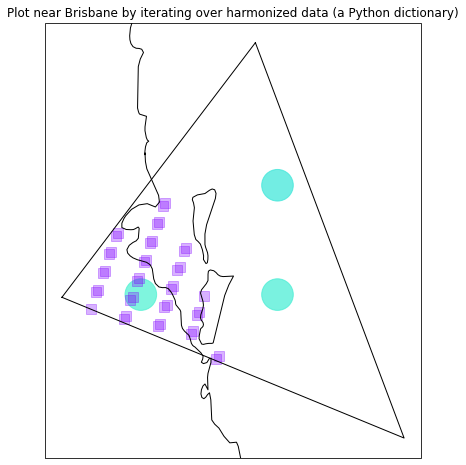

In [136]:
figax = hello_plot(show=False,figsize=(8,8)); 

# figax = hello_plot(list(harmonized_data.keys()),figax=figax,show=False,color='k')

# Set the neighborhood level and wipe out the unneeded fine resolution bits to determine the key.
key = gd.spatial_clear_to_resolution(gd.spatial_coerce_resolution(brisbane_siv,target_resolution)) # Just Brisbane

single = True
if single:
    keys = [key]; s_scale = 100 # Trixel of Brisbane
else:
    keys = roi2; s_scale = 1 # a circular cover

# Loop over the trixel containers
for key in keys:
    try:
        i = harmonized_data[key]
        if len(i.entry['merra2_lon']) > 0:
            plt.scatter(i.entry['merra2_lon'],i.entry['merra2_lat'],s=10*s_scale,c=i.entry['merra2'],transform=ccrs.PlateCarree()
                        ,cmap='rainbow',alpha=0.7
                        #,vmin=5.6690903,vmax=59.796043
                        ,vmin=0,vmax=59.796043
                        )
        if len(i.entry['modis_lon']) > 0:
            plt.scatter(i.entry['modis_lon'],i.entry['modis_lat'],s=1*s_scale,c=i.entry['modis'],transform=ccrs.PlateCarree()
                        ,cmap='rainbow',alpha=0.3,marker='s'
                        ,vmin=0.0,vmax=9.5
                        )
    except:
        pass
    # figax = hello_plot([key],figax=figax,show=False,color='k')
    
    figax = hello_plot(keys,figax=figax,show=False,color='k')
    
    if not single:
        figax = hello_plot(roi2,figax=figax,show=False,color='k')
        figax = hello_plot(roi0,figax=figax,show=False,color='g')
        figax.ax.plot(roi2_lo,roi2_la,transform=ccrs.PlateCarree())
        plt.title('Plot in ROI by iterating over harmonized data (a Python dictionary).\nNote this is similar to how to combine data at the Instrument Field of View (IFOV)')
    else:
        plt.title('Plot near Brisbane by iterating over harmonized data (a Python dictionary)')
        
plt.show()

In [139]:
# Some tests & check-ups
if False:
    figax = hello_plot(show=False)
    figax = hello_plot(roi2,figax=figax,show=False,color='k')
    figax.ax.plot(roi2_lo,roi2_la,transform=ccrs.PlateCarree())
    plt.show()
    
if False:
    figax = hello_plot(show=False)
    figax = hello_plot(roi0,figax=figax,show=False,color='g')
    figax.ax.plot(roi2_lo,roi2_la,transform=ccrs.PlateCarree())
    plt.show()

In [83]:
# Randomly select trixels of data

if False:
    # target_roi = subset_m2_index[1000:1001]-3
    rand_index = numpy.random.choice(subset_m2_index.shape[0], 10, replace=False)
    target_roi = subset_m2_index[rand_index]

    figax = hello_plot(show=False,figsize=(8,8)); 

    figax = hello_plot(subset_m2_index,figax=figax,show=False,color='k')
    figax = hello_plot(target_roi,figax=figax,show=False,color='red',lw=4)
    
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    plt.title('Or anything else...')
    plt.show()

In [84]:
# target_integrated_data = {}
# if True:
#     i = 0
#     tmp_roi = target_roi[i]
#     resolution = tmp_roi & 31
#     print(resolution)
#     print('%s\n%s'%(hex(tmp_roi),hex(gd.spatial_clear_to_resolution(gd.spatial_coerce_resolution(tmp_roi,resolution)))))
#     tmp_roi = gd.spatial_clear_to_resolution(gd.spatial_coerce_resolution(tmp_roi,resolution))
#     tmp_m2_idx = ps.intersects([tmp_roi],)

In [140]:
##### Toggle to close data set.
if False:
    ds.close()

In [86]:
# [o.mnmx() for o in intersected_objs2019356]

## Dask Acceleration

Let's integrate and analyze some data.


### Dask Preliminaries

In [87]:
import os
from dask_gateway import Gateway
from dask_gateway import GatewayCluster
from dask.distributed import Client


# Dask helpers
def slam(client,action,data,partition_factor=1.5,dbg=0,expected_np=0,pure=True):
    """
    A simple Dask driver that partitions data into shards, scattering them on client whose workers perform action on the shards. 
    Dask Futures are returned, which may then be gathered or simply waited upon. The parameter partition_factor establishes
    how many shards to construct, roughly partition_factor*n_procs. pure toggles memoization of task results. Set pure=False
    for no memoization.
    """
    np = sum(client.nthreads().values())
    if np < expected_np:
        return None
    if dbg>0: # a
        print('slam: len data = %i'%len(data))
        print('slam: nw = %i'%len(client.nthreads().values()))
        print('slam: np = %i'%np)
    shard_bounds = [int(i*len(data)/(1.0*partition_factor*np)) for i in range(int(partition_factor*np))]
    if shard_bounds[-1] != len(data):
        if dbg>0: # b
            print('a sb[-1]: ',shard_bounds[-1],len(data))
        shard_bounds = shard_bounds + [len(data)]
        if dbg>0: # c
            print('sb: ',shard_bounds)
    data_shards = [data[shard_bounds[i]:shard_bounds[i+1]] for i in range(len(shard_bounds)-1)]
    if dbg>0: # d
        print('ds len:        ',len(data_shards))
        print('ds item len:   ',len(data_shards[0]))
        print('ds type:       ',type(data_shards[0]))
        try:
            print('ds dtype:      ',data_shards[0].dtype)
        except:
            pass
    big_future = client.scatter(data_shards)
    results    = client.map(action,big_future,pure=pure)
    return results


In [88]:
gateway = Gateway(); gateway

Gateway<http://10.100.222.95:8000/services/dask-gateway>

In [89]:
if True:
    clusters = gateway.list_clusters(); pprint(clusters)

[ClusterReport<name=daskhub.fd3a2fb9478a4264b86a60ccd840de8c, status=PENDING>,
 ClusterReport<name=daskhub.286d06b40fc247928b672c51d7b63d09, status=PENDING>]


In [90]:
if False:
    for i in clusters:
        print(i); cluster = gateway.connect(i.name); cluster.shutdown()
if False:
    for i in clusters:
        print(i.name)

#### Dask cluster specification on SMCE is not completely automated.

Your setup may be different.

In [91]:
# Clusters must be made from images that have the STARE software stack installed
options = gateway.cluster_options(); options['image'] = 'rezuma/jh:smce-jdp-mike-03'; options

In [92]:
if False:
    cluster.shutdown()

In [93]:
cluster = gateway.new_cluster(cluster_options=options); cluster

In [94]:
# What clusters are available to our gateway?
clusters = gateway.list_clusters(); clusters

[ClusterReport<name=daskhub.fd3a2fb9478a4264b86a60ccd840de8c, status=PENDING>,
 ClusterReport<name=daskhub.286d06b40fc247928b672c51d7b63d09, status=PENDING>,
 ClusterReport<name=daskhub.29be7adc64a84458ba218bcc017027f2, status=RUNNING>]

In [95]:
# cluster = gateway.connect('daskhub.6f3d78cc545d4758a4e1c01d3c47c0fb')

In [96]:
# Connect to a cluster if one already exists.
if False:
    cluster = gateway.connect(clusters[2].name)

In [97]:
# cluster

In [98]:
# gateway

In [99]:
if False: # Safety
    cluster.shutdown()

### Example Parallelization

In the following action, load and harmonize data in parallel on workers into python dictionaries. Perform and return results of a simple analysis.

In [100]:
def action(data_shard):
    "An action to map to a Dask cluster that interprets a data shard. In this case, a list of STARE htm coordinates/trixels."
    
    # Note: this routine is an example of what the STARE search-load-processing looks like w/o visualization code.
    
    ret = []
    
    # Open a connection to s3
    s3_client = None
    attempts = 0
    while attempts < 3:
        attempts += 1
        try:
            s3_client = boto3.client('s3')
            break
        except KeyError:
            # Probably transient failure
            pass

    if True:
        # Retrieve the catalog
        bucket_name='daskhub-data'
        # TODO Undo this hardcoding
        key='MODAPS/CATALOGS/MOD05_L2/2019/356/catalogue.sqlite'
        tmpdir = tempfile.TemporaryDirectory()
        filename='catalogue.sqlite'
        fullFilename = os.path.join(tmpdir.name,filename)
    else:
        # not implemented
        # construct a catalog from a folder...
        pass
    
    s3_client.download_file(bucket_name,key,fullFilename)
    
    # TODO Replace this sql catalog load, with a construct catalog.
    # Load the catalog
    db_path = fullFilename
    uri = 'sqlite:///{db_path}'.format(db_path=db_path)
    engine = sqlalchemy.create_engine(uri)
    cataloga = pandas.read_sql(sql='catalogue', con=engine)
    # Convert to starepandas
    cataloga.stare_cover = cataloga.stare_cover.apply(func=numpy.frombuffer, args=('int64',))
    cataloga.geom = cataloga.geom.apply(shapely.wkb.loads, args=(True,))
    cataloga = starepandas.STAREDataFrame(cataloga, stare='stare_cover')

    # For example, load some MERRA-2.
    try:
        m2_ds = starepandas.nc4_Dataset_wrapper('s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191222.nc4')
    except Exception as e:
        ret.append((e))
        pass

    throttle=False
    
    for trixel in data_shard:
        entry = {}
        
        # Determine which data to load for this entry/trixel
        trixel_intersects = cataloga.stare_intersects(trixel)
        granule_subseta    = cataloga[trixel_intersects].granule_name
        
        if throttle:
            granule_namesa     = list(granule_subseta[0:2]) # note hardcoded limit for development
        else:
            granule_namesa     = list(granule_subseta)
    
        entry['g_names'] = len(granule_namesa)
        # ret.append((trixel,granule_namesa))
        
        # If there's at least one overlapping granule, the perform some analysis.
        if len(granule_namesa) > 0:
        
            # Load some data
            if True:
                data_objsa = [modis_data(name) for name in granule_namesa]
                entry['d_objs'] = len(data_objsa)
                # ret.append((trixel,True))
            
            # Trim
            if True:
                if throttle:
                    intersectionsa = [
                        ps.intersect([trixel],cataloga['stare_cover'][i].data,1) for i in granule_subseta.keys()[0:2] # note hardcoded limit for development
                    ]
                else:
                    intersectionsa = [
                        ps.intersect([trixel],cataloga['stare_cover'][i].data,1) for i in granule_subseta.keys() # note hardcoded limit for development
                    ]
                    
                entry['intersections'] = len(intersectionsa)
                # ret.append((trixel,intersectionsa))
            
            # Subset the original data, and do some analysis
            if True:
                try:
                    intersected_objsa = [modis_subset(data_objsa[i],intersectionsa[i]) for i in range(len(intersectionsa))]
                    entry['i_objs'] = len(intersected_objsa)
                    m2_data_size = sum([o.subset_wvir.size for o in intersected_objsa]) # number of points found
                    if m2_data_size > 0:
                        m2_wvir_avg  = sum([numpy.sum(o.subset_wvir) for o in intersected_objsa])/(1.0*m2_data_size)
                        m2_wvir_sig  = sum([numpy.sum((o.subset_wvir-m2_wvir_avg)**2) for o in intersected_objsa])/(1.0*(m2_data_size-1))
                    
                    ret.append([trixel,m2_data_size,m2_wvir_avg,m2_wvir_sig])
                except:
                    entry['i_objs']=('failed')
                    pass
            
        if False:
            ret.append([entry]) # Just save the whole thing for sending back to the master process.
    
    # Close that data file. Will analyze as above (for MODIS) in future.
    try:
        m2_ds.close()
    except:
        pass
    
    tmpdir.cleanup()
        
    return ret

#### Prepare for test runs

In [101]:
# m2_sc=merra2_sidecar(cover_resolution=3) # Neighborhood/resolution is about ~1300km per trixel
# m2_sc=merra2_sidecar(cover_resolution=5) # Neighborhood/resolution is about ~0.125*1300km per trixel
m2_sc=merra2_sidecar(cover_resolution=target_resolution) # Set harmonization scale to the target resolution from above (e.g. 6 for MERRA-2)
# data = m2_sc.cover[:100]
# data = m2_sc.cover[:10]
# data = m2_sc.cover # Whole planet, i.e. all MERRA-2 domain

# Set ROI (Domain of Dask analysis, called data here) to roi from before. Starting with Australia in the first version
data  = ps.expand_intervals(roi,int(target_resolution))

In [102]:
# Number of trixels in our ROI
print(len(data))

512


In [103]:
# What files ae we loading again?
# !~/opt/local/bin/aws s3 ls s3://daskhub-data/GESDISC/MERRA2/2019/

### Run on the Dask cluster (once)

In [104]:
# Run on the Dask cluster
run_once = False

if run_once: # safety
    client = cluster.get_client()
    results = slam(client,action,data,partition_factor=3,dbg=1)

In [105]:
# results

In [106]:
# Note: If you close the client before using the results, you will lose the results.
if False:
    client.close()
    cluster.shutdown()

### Performance testing

#### Preliminaries

In [107]:
# What clusters are available to our gateway?
# clusters = gateway.list_clusters(); clusters

In [108]:
# Make a new cluster
# cluster = gateway.new_cluster(cluster_options=options); cluster

In [109]:
# Or connect to one
# cluster = gateway.connect(clusters[2].name)

In [110]:
# Take a look at the cluster
# cluster

In [111]:
# Shut it down, e.g. if it's excess.
# cluster.shutdown()

In [112]:
# Get a client for the test runs
client = cluster.get_client()

In [113]:
# It can be helpful to scale a cluster early, because sometimes it takes some time to secure the needed workers.
nworkers = 8
cluster.scale(nworkers)

In [123]:
# Check the client to see what resources are available, may be less than requested if cluster isn't fully up.
client.nthreads().values()

dict_values([2, 2, 2, 2])

In [115]:
def wait_for(client,nworkers,n_attempts=3,delay=0.0625):
    "Wait until the number of workers available equals the expected. This is useful for scaling and performance testing."
    attempts = 0
    ok = False
    delay0 = 0
    while attempts < n_attempts:
        time.sleep(delay0)
        attempts += 1
        if len(client.nthreads().values()) == nworkers:
            ok = True
            break
        else:
            delay0 += delay
    return ok

In [116]:
# test
# wait_for(client,1)

In [117]:
if False: # safety
    cluster.shutdown()

In [118]:
# client = cluster.get_client()
# cluster.scale(2)

#### Configure a test run

In [119]:
timing_runs_counter = 0
timing_runs_results = {}
results=[]

In [120]:
# partition_factor = 1 => ~1 partition (data shard) per processor, note there may be multiple procs per worker.
partition_factor = 1.5
# Also note we're working on 1 day of MODIS data, 512 trixels.

#### Execute a run

In [124]:
if True:
    nworkers = 4
    results  = [] # We don't need to store...
    scale0 = wall_clock()
    cluster.scale(nworkers)
    scale1 = wall_clock()
    if wait_for(client,nworkers,n_attempts=10,delay=4):
        st0 = wall_clock()
        results.append(slam(client,action,data.copy(),partition_factor=partition_factor,dbg=1,pure=False))
        client.gather(results)
        st1 = wall_clock()
        print('nworkers,nw, wall-clock calc-time ',nworkers,len(client.nthreads().values()),st1-st0)
        nw = len(client.nthreads().values())
        print('nw = nworkers: %i == %i ',(nw,nworkers))
        try:
            timing_runs_results[nw].append([timing_runs_counter,nworkers,st1-st0])
        except KeyError:
            timing_runs_results[nw]=[]
            timing_runs_results[nw].append([timing_runs_counter,nworkers,st1-st0])
        timing_runs_counter = timing_runs_counter+1
        print('\n***timing run done***\n')
    else:
        print('Workers:  ',client.nthreads().values())
        print('nWorkers: ',len(client.nthreads().values()))
        print('timeout on startup')
        print('---timing run unsuccessful---')


slam: len data = 512
slam: nw = 4
slam: np = 8
a sb[-1]:  469 512
sb:  [0, 42, 85, 128, 170, 213, 256, 298, 341, 384, 426, 469, 512]
ds len:         12
ds item len:    42
ds type:        <class 'list'>
nworkers,nw, wall-clock calc-time  4 4 380.7088248729706
nw = nworkers: %i == %i  (4, 4)

***timing run done***



In [125]:
# If we only need to keep one set of results, subset here. Note: later examples work on a list of results, not a list of a list of results.
results = results[0]

In [126]:
# Save results, lest they be cancelled upon closing the client.
results_list = list(map(lambda r : list(r.result()),results))

# Explicitly set results list so that it is constructed later.
# results_list = None

In [127]:
# Take a look to copy and save to the later cells for persistence.
# Format is { nw: [[run-iter-number, nw, timing], ... ] }
timing_runs_results

{4: [[0, 4, 380.7088248729706]]}

In [128]:
# partition_factor=3; nw=2; nproc=2*nw
timing_runs_results_2020_1103 = \
{1: [[0, 1, 1263.7364621162415],
  [1, 1, 1254.713942527771],
  [2, 1, 1253.0105383396149]],
 2: [[3, 2, 688.1622486114502],
  [4, 2, 698.8750190734863],
  [5, 2, 708.8736765384674]],
 8: [[6, 8, 230.19696521759033],
  [7, 8, 243.91781973838806],
  [8, 8, 216.75991773605347],
  [18, 8, 198.44755697250366],
  [19, 8, 204.18279600143433]],
 10: [[9, 10, 167.5860993862152],
  [10, 10, 173.73951268196106],
  [11, 10, 165.2656126022339]],
 16: [[12, 16, 156.2444806098938],
  [13, 16, 164.61399912834167],
  [14, 16, 152.39045929908752]],
 6: [[15, 6, 251.78134894371033],
  [16, 6, 251.17031717300415],
  [17, 6, 252.1872479915619]]}

In [129]:
# partition_factor=3; nw=2; nproc=2*nw
timing_runs_results_2020_1102 = \
{4: [[0, 4, 409.3730809688568],
#   [1, 4, 0.02514481544494629], # pure=True by default on Dask map
#   [2, 4, 0.025177478790283203],
#   [3, 4, 0.02585911750793457],
#   [4, 4, 0.02665543556213379],
  [5, 4, 413.152051448822],
  [6, 4, 406.53220438957214]],
 6: [[7, 6, 320.92422914505005],
  [8, 6, 333.54933404922485],
  [9, 6, 339.55571389198303]],
 10: [[10, 10, 252.14148592948914],
  [11, 10, 234.05842638015747],
  [12, 10, 231.54729390144348]]}

In [130]:
timings_collected = SortedDict()
timings_collected.update(timing_runs_results_2020_1102)
timings_collected.update(timing_runs_results_2020_1103)

In [131]:
nw_vs_t = list(zip(*[(k[0],sum(k[1])/len(k[1]),) for k in [(i,[j[2] for j in timings_collected[i]],) for i in timings_collected]]))
nw,t = nw_vs_t[0],nw_vs_t[1]

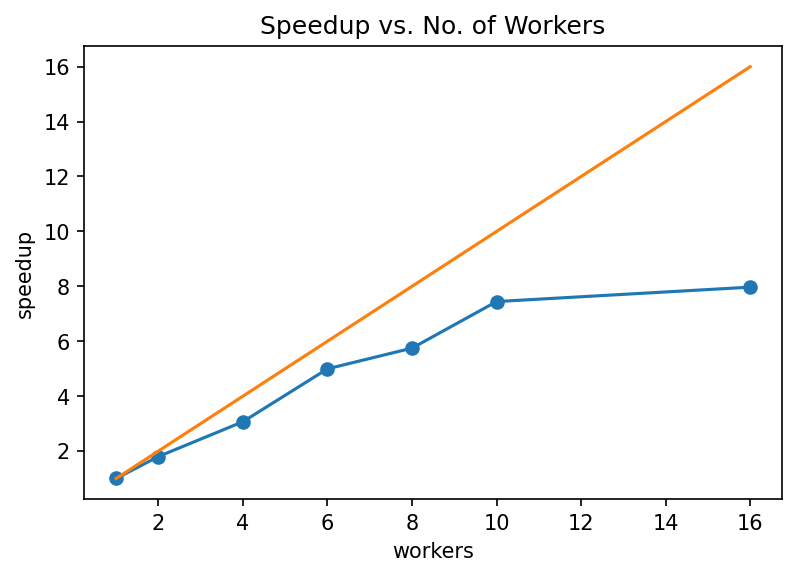

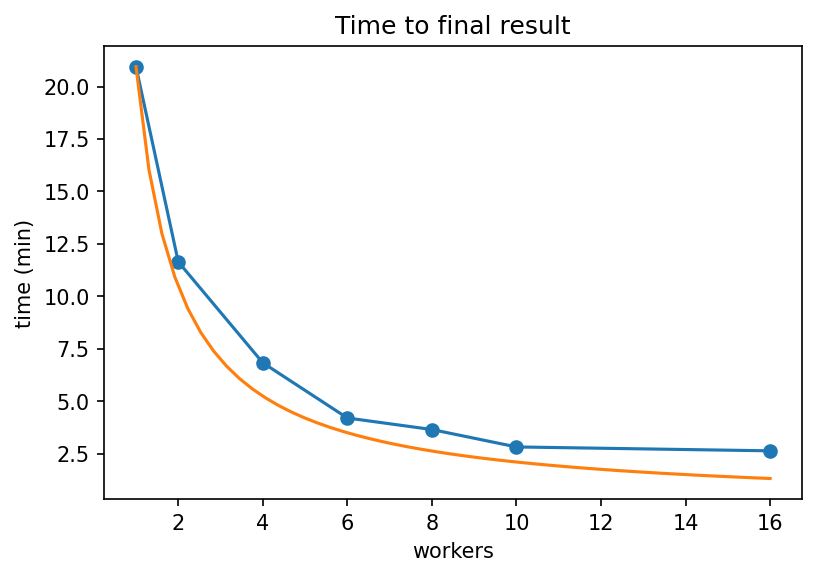

In [132]:
fig, ax = plt.subplots()

nw = numpy.array(nw)
t = numpy.array(t)

plt.plot(nw,(1.0/t)*t[0])
plt.scatter(nw,(1.0/t)*t[0])
scale = nw[0]*t[0]/t[0]

nw0 = numpy.linspace(1,numpy.amax(nw))
plt.plot(nw0,nw0/scale)
plt.title('Speedup vs. No. of Workers')
ax.set_xlabel('workers')
ax.set_ylabel('speedup')
plt.show()

fig, ax = plt.subplots()


time_unit = 60 # seconds
plt.plot(nw,t/time_unit)
plt.scatter(nw,t/time_unit)
scale = nw[0]*t[0]

nw0 = numpy.linspace(1,numpy.amax(nw))
plt.plot(nw0,(scale/nw0)/time_unit)
plt.title('Time to final result')
ax.set_xlabel('workers')
ax.set_ylabel('time (min)')

plt.show()

# Data size chosen for demonstartion purposes. Saturation at ~10 workers due to relatively small total data volume.

Note: This performance was obtained without any special tuning or refactoring, and is thus preliminary as a measure.

### Dask cleanup...
But be careful, we may still need client open to read the results!

In [133]:
client.close()

In [134]:
cluster.shutdown()

In [135]:
clusters = gateway.list_clusters(); clusters

[ClusterReport<name=daskhub.fd3a2fb9478a4264b86a60ccd840de8c, status=PENDING>,
 ClusterReport<name=daskhub.286d06b40fc247928b672c51d7b63d09, status=PENDING>,
 ClusterReport<name=daskhub.29be7adc64a84458ba218bcc017027f2, status=RUNNING>]

In [136]:
# gateway.connect(clusters[-1].name).shutdown()

#### Save the results list for further visualization or processing

In [137]:
if results_list is None:
    results_list = list(map(lambda r : list(r.result()),results))

In [138]:
type(results_list)

list

In [139]:
# Take a look. Note the format: STARE spatial ID, No. of observations, Avg. Water Vapor, Std. Dev. Water Vapor
# results_list[3]

#### Get the minimum and maximum values to aid visualization

In [140]:
# Entries are of form [trixel,m2_data_size,m2_wvir_avg,m2_wvir_sig]
# Only doing the last 3 elements
#
rmx = [-1,-1,-1]
for r in results_list:
    for e in r:
        # print(e)
        for j in [1,2,3]:
            if rmx[j-1] < e[j]:
                rmx[j-1] = e[j]
rmx

[355383, 3.2926732022552585, 6.313445491124454]

In [141]:
# client.gather(results)

#### Visualizations...

In [142]:
cmap=plt.cm.get_cmap('rainbow')

In [143]:
# Diagnostic
if False:
    figax = hello_plot(show=False)
    cscale = 1.0/355383.0
    r = results_list[0]
    # r = results[0]
    # e = r.result()[0]
    e = r[0]
    hello_plot([e[0]],color=cmap(e[1]*cscale),figax=figax,show=False)
    plt.title('The "first" trixel (python dict entry) in the results')
    plt.show()

In [144]:
# Current format: 
e

[4602678819172646915, 82340, 0.7986649031276473, 0.14003164177670802]

In [145]:
# results_list

### Loop over the results and their (per pixel) entries

Note we are looping over STARE "trixels" in the following.

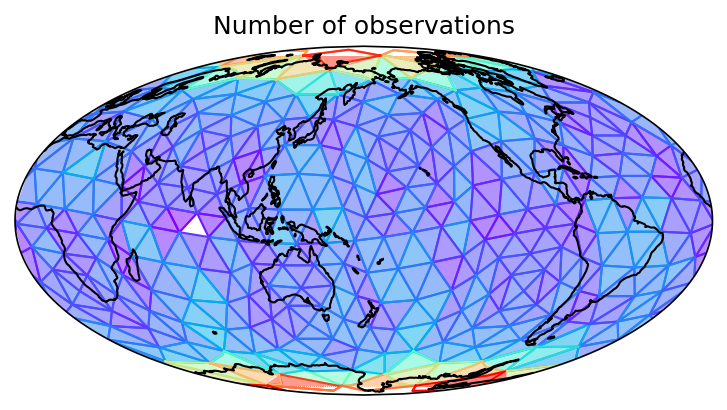

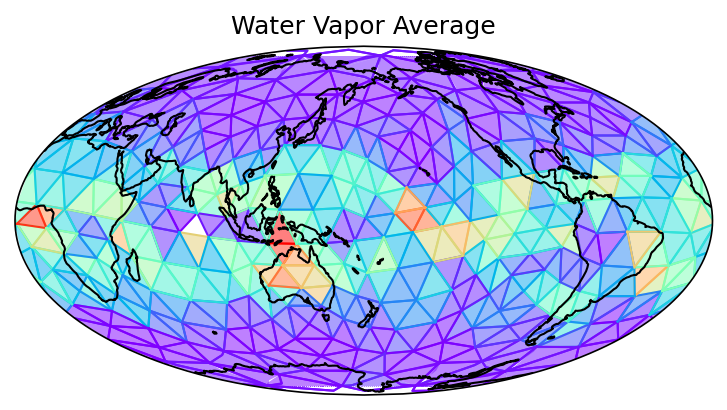

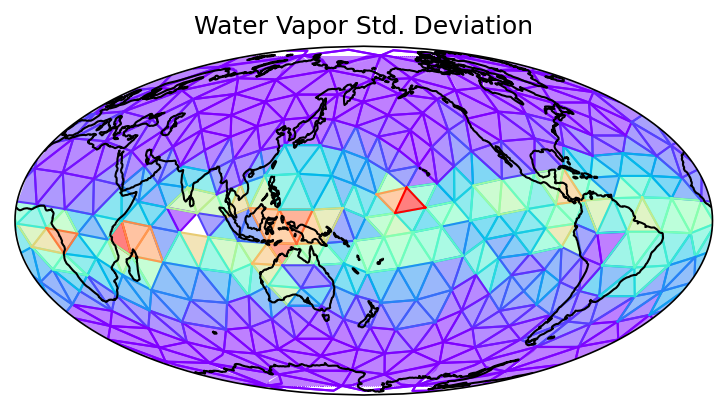

Wall clock timing:  49.60830903053284


In [146]:
wc_a = wall_clock()

results = results_list
vmin = 0; vmax = 1
cmap=plt.cm.get_cmap('rainbow')

# proj=ccrs.PlateCarree(); transf=ccrs.Geodetic();
# proj=ccrs.Sinusoidal(central_longitude=170); transf=ccrs.Geodetic();
proj = ccrs.Mollweide(central_longitude=170); transf=ccrs.Geodetic();

plot_options = {'projection':proj,'transform':transf}

title=["Number of observations","Water Vapor Average","Water Vapor Std. Deviation"]

j = 0 # for rmx 0 for no., 1 for avg, 2 for std-dev
for j in [0,1,2]:
    figax = hello_plot(show=False,plot_options=plot_options)
    cscale = 1.0/rmx[j]
    for r in results:
        # for e in r.result():
        for e in r:
            figax = hello_plot([e[0]],color=cmap(e[j+1]*cscale),figax=figax,show=False)
        
            if True:
                eInfo = spatial_info([e[0]])
                cd_plt = numpy.array([e[j+1]])*cscale
                if False:
                    print(e[0],'triang: ',eInfo.triang)
                    print(e[0],'cd_plt: ',cd_plt)
                    print(e[0],' lons ',eInfo.lons)
                figax.ax.tripcolor(eInfo.triang
                                   ,facecolors=cd_plt
                                   ,edgecolors='k'
                                   ,lw=0
                                   ,shading='flat'
                                   ,vmin=vmin,vmax=vmax
                                   ,cmap=cmap
                                   ,alpha=0.5
                                   ,transform=ccrs.PlateCarree()
                                  )
    plt.title(title[j])
    plt.show()
    
print('Wall clock timing: ',wall_clock()-wc_a)

# Note matplotlib.tri+cartopy has trouble coloring faces at the poles.

#### Dask clean up if needed

In [147]:
if False:
    client.close();

In [148]:
if False:
    cluster.shutdown();

In [149]:
clusters = gateway.list_clusters(); clusters

[ClusterReport<name=daskhub.fd3a2fb9478a4264b86a60ccd840de8c, status=PENDING>,
 ClusterReport<name=daskhub.286d06b40fc247928b672c51d7b63d09, status=PENDING>]

In [150]:
print('Total wall clock time: ',wall_clock()-wc0)

Total wall clock time:  1778.3207585811615


# Conclusion

- STARE is a breakthrough in Earth Science data analysis -- it is now feasible to co-align diverse data at its highest resolution
- By using integers with spatiotemporal semantics we have powerful integrative capabilities in **just a few lines of code!**
- **Diverse data is handled in a uniform way**: point, grid, swath, trajectories, networks...
- End users can choose the mode of integration: gridded vs. non-gridded, **or even at the instrument foot-point or field-of-view**
- STARE helps co-align and organize data for use on distributed systems, like NASA's Science Managed Cloud Environment

**STARE helps Earth Science data analysis scale in volume and variety, enabling important previously infeasible analyses.**


### How to start STARE'ing

STARE is in a final stage of development for supporting large scale search, subsetting, and integrative analyses. Features and fixes are implemented continuously. Let us know your needs.

STARE is available at https://github/SpatioTemporal where [this demo](https://github.com/SpatioTemporal/STARE-Cookbooks/blob/daskhub/contrib/jupyter/2020-ACM-SIGSPATIAL20-STARE%2BDask-Demo.ipynb) can be found in the [STARE Cookbooks](https://github.com/SpatioTemporal/STARE-Cookbooks/).  

Visit the links for more information about NASA's new [Science Managed Cloud Environment](https://www.nccs.nasa.gov/systems/SMCE) and the [NASA Center for Climate Simulation](https://www.nccs.nasa.gov/).